In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fpipe.point_source import source
import healpy as hp
import h5py as h5
import numpy as np
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from fpipe.map import algebra as al
from fpipe.plot import plot_map

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from scipy.interpolate import interp1d

from astropy.coordinates import SkyCoord
from astropy import units as u

In [3]:
import astropy.io.fits as pyfits

In [4]:
data = np.loadtxt('/users/ycli/code/fpipe/fpipe/data/fwhm.dat')
f = data[4:, 0] #* 1.e-3
d = data[4:, 1:]
fwhm = interp1d(f, np.mean(d, axis=1), fill_value="extrapolate")(np.linspace(1400-25, 1400+25, 100))
#fwhm /= 60. # deg

print fwhm.max()

2.933421052631579


In [4]:
def isolate_source(nvss_ra, nvss_dec, nvss_flx, nvss_name, threshold=2.):

    r = np.sin(np.radians(nvss_dec[:, None])) * np.sin(np.radians(nvss_dec[None, :])) \
      + np.cos(np.radians(nvss_dec[:, None])) * np.cos(np.radians(nvss_dec[None, :])) \
      * np.cos(np.radians( nvss_ra[:, None])  - np.radians(nvss_ra[None, :]))
    r[r>1] = 1.
    r = np.rad2deg(np.arccos(r))
    r[r==0] = 1000
    bad = r < threshold/60.
    
    bad = np.any(bad, axis=0)
    
    print '%d of %d sources removed with threshold cut %f arcmin'%(np.sum(bad), bad.shape[0], threshold)
    
    del r
    gc.collect()
    
    return nvss_ra[~bad], nvss_dec[~bad], nvss_flx[~bad], nvss_name[~bad]

def load_catalogue(nvss_path_list, nvss_range, flux_key, name_key, flux_lim=10, threshold=0):
    
    nvss_ra, nvss_dec, nvss_flx, nvss_name = [], [], [], []
    for nvss_path in nvss_path_list:
        nvss_cat = source.get_nvss_radec(nvss_path, nvss_range)
        #print nvss_cat['RA'].min(), nvss_cat['RA'].max()

        nvss_sel = nvss_cat[flux_key] > flux_lim
        nvss_ra.append(nvss_cat['RA'][nvss_sel])
        nvss_dec.append(nvss_cat['DEC'][nvss_sel])
        nvss_flx.append(nvss_cat[flux_key][nvss_sel])
        nvss_name.append(nvss_cat[name_key][nvss_sel])

        del nvss_cat
        gc.collect()

    nvss_ra = np.concatenate(nvss_ra, axis=0)
    nvss_dec = np.concatenate(nvss_dec, axis=0)
    nvss_flx = np.concatenate(nvss_flx, axis=0)
    nvss_name = np.concatenate(nvss_name, axis=0)
    
    ## remove redundancy according to name
    nvss_name, redu = np.unique(nvss_name, return_index=True)
    nvss_ra  = nvss_ra[redu]
    nvss_dec = nvss_dec[redu]
    nvss_flx = nvss_flx[redu]
    
    if threshold > 0:
        return isolate_source(nvss_ra, nvss_dec, nvss_flx, nvss_name)
    
    return nvss_ra, nvss_dec, nvss_flx, nvss_name


In [5]:
def _get_spec(imap, nmap, pixs, ra, dec, nside, beam_sig, r1=None):
    
    noise_inv = np.ma.filled(nmap.copy(), 0)
    #noise_inv[noise_inv==0] = np.inf
    #noise_inv  = 1./noise_inv

    p_ra, p_dec = hp.pix2ang(nside, hp.ang2pix(nside, ra, dec, lonlat=True), lonlat=True)

    beam_fwhm = beam_sig * 2. * np.sqrt( 2. * np.log(2.) )
    pointing = hp.ang2vec(ra, dec, lonlat=True)
    
    # get pix index of inner circle
    if r1 is None:
        r1 = np.median( beam_fwhm / 2. )
    _p = hp.query_disc(nside, pointing, r1 * np.pi / 180., inclusive=True)
    
    # get pix index of outer circle 
    r2 = (2**0.5) * r1 * 2
    _p1 = hp.query_disc(nside, pointing, r1 * 2 * np.pi / 180., inclusive=True)
    _p2 = hp.query_disc(nside, pointing, r2 * np.pi / 180., inclusive=True)
    _p2 = np.array([x for x in _p2 if x not in _p1])
    if _p2.shape[0] == 0:
        print '10% enlarge outer circel to include pixels'
        r2 = (2**0.5) * r1 * 2 * 1.1
        _p2 = hp.query_disc(nside, pointing, r2 * np.pi / 180., inclusive=True)
        _p2 = np.array([x for x in _p2 if x not in _p])

    # get spec of inner circle
    _ra, _dec = hp.pix2ang(nside, _p, lonlat=True)
    dra = (_ra - ra) * np.cos(dec*np.pi/180.) # deg
    ddec = _dec - dec # deg
    rr = (dra**2 + ddec**2 ) ** 0.5
    _w = np.exp( - 0.5 * ( rr[None, :] / beam_sig[:, None] ) ** 2. )

    spec = []
    noise = [] # it is noise inv
    for i in range(_p.shape[0]):
        _idx = (pixs - _p[i]) == 0
        if np.any(_idx) :
            noise.append( noise_inv[:, _idx])
            spec.append( imap[:, _idx] * noise_inv[:, _idx] )
            _w[(spec[-1] == 0).flat, i] = 0.
            _w[:, i] *= noise_inv[:, _idx].flat
        else:
            _w[:, i] = 0.
        del _idx
    if len(spec) == 0: return None
    spec = np.concatenate(spec, axis=1)
    spec = np.ma.masked_invalid(spec)
    _w = np.ma.masked_invalid(_w)
    spec_m = np.ma.sum(spec, axis=1) / np.ma.sum(_w, axis=1)
    del spec

    noise = np.concatenate(noise, axis=1)
    noise = np.ma.masked_invalid(noise)
    #noise_m = np.ma.sum(noise, axis=1) / np.ma.sum(_w, axis=1)
    noise[noise==0] = np.ma.masked
    noise_m = np.ma.mean(noise, axis=1)
    del noise
    # convert to noise error
    noise_m = np.ma.filled(noise_m, 0)
    noise_m[noise_m==0] = np.inf
    noise_m = 1./noise_m
    noise_m = np.ma.sqrt(noise_m)
    
    # get spec of outer circle
    _w = np.ones( (beam_sig.shape[0], _p2.shape[0]))
    spec = []
    noise = [] # it is noise inv
    for i in range(_p2.shape[0]):
        _idx = (pixs - _p2[i]) == 0
        if np.any(_idx) :
            noise.append( noise_inv[:, _idx])
            spec.append( imap[:, _idx] * noise_inv[:, _idx] )
            _w[(spec[-1] == 0).flat, i] = 0.
            _w[:, i] *= noise_inv[:, _idx].flat
        else:
            _w[:, i] = 0.
        del _idx
    spec = np.concatenate(spec, axis=1)
    spec = np.ma.masked_invalid(spec)
    _w = np.ma.masked_invalid(_w)
    spec_m_out = np.ma.sum(spec, axis=1) / np.ma.sum(_w, axis=1)
    del spec
    
    mask = ( spec_m == 0 ) + (spec_m_out == 0)
    spec_m = spec_m - spec_m_out
    spec_m[mask] = 0

    return p_ra, p_dec, spec_m, noise_m

def get_map_spec(imap_info, ra, dec, freq, mJy=False):

    imap, pixs, nside, nmap = imap_info
    #freq = imap.get_axis('freq')
    #if freq_sel is None:
    #    freq_sel = np.ones(freq.shape, dtype='bool')
    #freq = freq[freq_sel]
    #imap = imap[freq_sel]
    #nmap = nmap[freq_sel]

    # load beam size data
    data = np.loadtxt('/users/ycli/code/fpipe/fpipe/data/fwhm.dat')
    f = data[4:, 0] #* 1.e-3
    d = data[4:, 1:]
    fwhm = interp1d(f, np.mean(d, axis=1), fill_value="extrapolate")(freq)
    fwhm /= 60. # deg
    beam_sig = (fwhm / (2. * np.sqrt(2.*np.log(2.))))

    #r1 = hp.nside2resol(nside, arcmin=True) / 60. 
    #r1 = np.max( fwhm / 2. ) * 1.0
    r1 = np.max( fwhm ) * 1.0
    _r = _get_spec(imap, nmap, pixs, ra, dec, nside, beam_sig, r1=r1)
    if _r is None:
        return None
    p_ra, p_dec, spec_m, noise_m =  _r
    #_r = _get_spec(imap, nmap, pixs, ra, dec, nside, beam_sig, factor=2.**0.5)
    #if _r is None:
    #    return None
    #spec_m = 2 * spec_m - _r[2]

    if mJy:
        eta = 1.0
        _lambda = 2.99e8 / (freq * 1.e6)
        _Omega = np.pi * (fwhm * np.pi/180.)**2. / 4. / np.log(2.)
        _K2mJy = 2. * 1380. / (_lambda**2.) * 1.e3 * _Omega
        spec_m   = spec_m  * _K2mJy #* 2. #* 0.5
        noise_m  = noise_m * _K2mJy #* 2. #* 0.5

    return spec_m, p_ra, p_dec, noise_m

In [6]:
def load_nvss_by_beam(file_list, beam_list=None, dlim=0.5):
    if beam_list is None:
        beam_list = range(1, 20)
    for beam in beam_list:
        BEAM = 'B%02d/'%beam
    
        for file in file_list:
            with h5.File(file, 'r') as f:
                s_list = f[BEAM].keys()
                for s in s_list:
                    d = f[BEAM + s + '/BEAM_DIST'][:]
                    r = f[BEAM + s + '/FLUXRADEC'][:]
                    indx = np.argmin(d)
                    tod_flux = f[BEAM + s + '/FAST_FLUX'][indx]
                    mod_flux = f[BEAM + s + '/NVSS_FLUX'][indx]
                    if d.min() <= dlim:
                        yield s, r[0], r[1], r[2], np.sum(tod_flux)/2., d[indx], mod_flux
                        
def find_nvss(source_name_list, beam, file_list):
    BEAM = 'B%02d/'%beam
    for source_name in source_name_list:
        s = '%d'%source_name
        d = []
        for file in file_list:
            with h5.File(file, 'r') as f:
                try:
                    d.append(f[BEAM + s + '/BEAM_DIST'][:].min())
                except KeyError:
                    continue
        if len(d) == 0:
            raise(ValueError('no source found'))
        elif len(d) > 1:
            raise(ValueError('multi source found'))
        else:
            yield d[0]
                

In [7]:
def load_nvss_flux_from_map(map_info, nvss_list, nvss_map_info, output_path=None, f0 = 1400, df=25, 
                            flag_iter=5, beam_list=[1, ],dlim=1.):

    imap, pixs, nside, nmap = map_info
    
    nvss_map, pixs_nvss, nside_nvss = nvss_map_info

    spec_list = []
    spec_erro = []
    tod_list = []
    nvss_flux = []
    nvss_dflux = []
    nvss_flux_from_map = []
    nvss_flux_with_beam = []
    nvss_name = []

    freq_imap = imap.get_axis('freq')
    freq_sel = (freq_imap > f0 - df) * (freq_imap < f0 + df)
    
    freq = imap.get_axis('freq')
    freq = freq[freq_sel]
    imap = imap[freq_sel]
    nmap = nmap[freq_sel]
    map_info = [imap, pixs, nside, nmap]

    for _s in load_nvss_by_beam(nvss_list, beam_list, dlim=dlim):
        s_name, s_flux, s_ra, s_dec, tod_flux, d, s_flux_w_beam = _s
        #print s_name, s_flux

        _r = get_map_spec(map_info, s_ra, s_dec, freq, mJy=True)
        if _r is not None:
            spec, p_ra, p_dec, error = _r
        else:
            continue
        spec = np.ma.masked_equal(spec, 0)
        _w = 1.

        if not (np.all(spec.mask) or spec.shape[0] == 0):
            try:
                _pix = hp.ang2pix(nside_nvss, s_ra, s_dec, lonlat=True)
                _pix = np.where(pixs_nvss == _pix)[0][0]
                nvss_flux_from_map.append(nvss_map[_pix])
                nvss_flux_with_beam.append(s_flux_w_beam)
                spec_list.append(spec/_w)
                spec_erro.append(error/_w)
                nvss_flux.append(s_flux)
                tod_list.append(tod_flux)
                nvss_dflux.append(0.)
                nvss_name.append([s_name, '%18.7f'%s_ra, '%18.7f'%s_dec])
            except IndexError:
                print s_ra, s_dec

        del spec, error, _r
        gc.collect()

    spec = np.ma.array(spec_list)
    spec.mask = spec==0

    error = np.ma.array(spec_erro)
    error.mask = spec==0

    for i in range(flag_iter):
        flux = np.ma.median(spec, axis=1)
        dflux = np.ma.std(spec - flux[:, None], axis=1)

        mask = np.ma.abs( spec - flux[:, None] ) - 2. * dflux[:, None] > 0
        if not np.any(mask): break
        #print np.sum(mask.astype('int'))
        spec.mask[mask] = True
        error.mask[mask] = True
    #fig2 = plt.figure()
    #ax2 = fig2.add_axes([0.1, 0.1, 0.85, 0.85])
    #for i in range(spec.shape[0]):
    #    ax2.plot(spec[i])
    #plt.show()
        
    #print np.sum(spec.mask.astype('int'))
    nfreq = np.sum((~spec.mask).astype('int'), axis=1) #spec.shape[1]
    #spec = np.ma.filled(spec, 0)
    #norm = np.sum( ( spec != 0 ).astype('int'), axis=1 ) * 1.
    #flux = np.sum(spec, axis=1) / norm
    flux = np.ma.median(spec, axis=1)
    #flux = np.ma.mean(spec, axis=1)
    dflux = np.ma.std(spec[:, :-1] - spec[:, 1:], axis=1) / np.sqrt(nfreq) / np.sqrt(2.)

    error = error ** 2.
    error[error==0] = np.inf
    #error = 1./error
    #error = 1./np.sqrt(np.ma.mean(error**2, axis=1))
    error = np.ma.sum(1./error, axis=1)
    error[error==0] = np.inf
    error = np.sqrt(1./error)
    #error[error==0] = np.inf

    nvss_name = np.array(nvss_name)
    nvss_flux = np.array(nvss_flux)
    nvss_flux_from_map = np.array(nvss_flux_from_map)
    nvss_flux_with_beam = np.array(nvss_flux_with_beam)
    tod_list = np.array(tod_list)
    return nvss_name, nvss_flux, nvss_flux_from_map, spec, \
           flux, dflux, error, nvss_dflux, tod_list, nvss_flux_with_beam

In [8]:
def output_flux_beam(map_info, nvss_list, nvss_map_info, beam_list=[1, ], axes=None, dlim=1.,
                    flux_diff_path = None):
    
    if axes is None:
        fig = plt.figure(figsize = (6, 6))
        ax = fig.subplots()
    else:
        fig, ax = axes
    
    xx = np.linspace(0.01, 10., 110)
    ax.plot(xx, xx, 'k-', zorder=1000)
    
    #ax.plot(xx, xx + xx, 'k--', zorder=1000)
    #ax.plot(xx + xx, xx, 'k--', zorder=1000)
    
    legend_list = []
    for i in beam_list:
        nvss_name, nvss_flux, nvss_flux_from_map, spec_list, flux, dflux, \
        error, nvss_dflux, tod_flux, nvss_flux_with_beam\
            = load_nvss_flux_from_map(map_info, nvss_list, nvss_map_info, f0=1400, df=25, 
                                      flag_iter=10, beam_list=[i, ], dlim=dlim)
        #x = nvss_flux_from_map * 1.e-3
        x = nvss_flux * 1.e-3
        y = flux * 1.e-3
        #y = tod_flux * 1.e-3
        #dx = dflux * 1.e-3
        dy = dflux * 1.e-3
        #l = ax.errorbar(x, y, dy, fmt='o', ms=4, lw=0.8, mec='none', zorder=2000)[0]
        l = ax.plot(x, y, 'o', ms=4)[0]
        legend_list.append(mpatches.Patch(color=l.get_color(), label='Feed %02d'%i))
        
        diff1 = np.abs( nvss_flux_from_map - flux ) / nvss_flux_from_map
        diff2 = np.abs( nvss_flux_from_map - flux ) / flux
        sel = ( diff1 > 1 ) + (diff2 > 1)
        bad = nvss_name[sel, :]
        ax.plot(x[sel], y[sel], 'ko', ms=8, mfc='none', mew=0.5)
        print 'Beam %02d'%i
        for ii in range(bad.shape[0]):
            if ( x[sel][ii] > 0.01 ) and ( y[sel][ii] > 0.01 ):
                print '%s %s %s'%tuple(bad[ii]) + ' %f %f'%(x[sel][ii], y[sel][ii])
        if flux_diff_path is not None:
            #print nvss_name.shape
            #print nvss_flux_from_map.shape
            #print flux.shape
            _data = np.zeros(flux.shape, dtype=[('NAME', 'S10'), ('RA', 'S10'), ('DEC', 'S10'),
                                                ('NVSS', float), ('FAST', float),
                                                ('TOD', float), ('NVSS_CAT', float),
                                                ('NVSS_BEAM', float)])
            _data['NAME'] = nvss_name[:, 0]
            _data['RA']   = nvss_name[:, 1]
            _data['DEC']  = nvss_name[:, 2]
            _data['NVSS'] = nvss_flux_from_map
            _data['FAST'] = flux
            _data['TOD'] = tod_flux
            _data['NVSS_CAT'] = nvss_flux
            _data['NVSS_BEAM'] = nvss_flux_with_beam
            np.savetxt(flux_diff_path + '_beam%02d.txt'%i, _data, 
                       fmt="%10s %10s %10s %10.5f %10.5f %10.5f %10.5f %10.5f")
        #fig2 = plt.figure()
        #ax2 = fig2.add_axes([0.1, 0.1, 0.85, 0.85])
        #for i in range(spec_list.shape[0]):
        #    ax2.plot(spec_list[i])
        #plt.show()
        
        
    
    ax.set_xlim(0.01, 1.5)
    ax.set_ylim(0.01, 1.5)
    ax.loglog()
    ax.legend(handles=legend_list, frameon=False, markerfirst=True)
    ax.set_aspect('equal')
    if axes is None:
        ax.set_xlabel('NVSS Flux at 20cm (Jy)')
        ax.set_ylabel('Measured Flux at 1400 MHz (Jy)')

    return fig, ax

In [9]:
def plot_flux_beam(flux_diff_path, beam_list=[1, ], axes=None, tod=False,
                   nvss_file_list=None, d_bins = [0, 0.5, 1.0, 1.5]):
    
    if d_bins is not None:
        cnorm = mpl.colors.Normalize(min(d_bins), vmax=max(d_bins))
    
    if axes is None:
        fig = plt.figure(figsize = (6, 6))
        ax = fig.subplots()
    else:
        fig, ax = axes
    
    xx = np.linspace(10, 1000., 110)
    ax.plot(xx, xx, 'k-', zorder=1000)
    
    #ax.plot(xx, xx + xx, 'k--', zorder=1000)
    #ax.plot(xx + xx, xx, 'k--', zorder=1000)
    
    legend_list = []
    for i in beam_list:
        data_flux_diff = np.loadtxt(flux_diff_path + '_beam%02d.txt'%i)
        
        nvss_name = data_flux_diff[:, :3]
        if nvss_file_list is not None:
            d_list = [x for x in find_nvss(nvss_name[:, 0], i, nvss_file_list)]
        d_list = np.array(d_list)
        #print data_flux_diff.shape
        if tod:
            #y = data_flux_diff[:, 7]
            y = data_flux_diff[:, 5]
            x = data_flux_diff[:, 7] # tod model with beam
        else:
            y = data_flux_diff[:, 4]
            x = data_flux_diff[:, 6]
        
        #x = data_flux_diff[:, 3]
        
        if d_bins is not None:
            ax.scatter(x, y, marker='o', s=15, c=cnorm(d_list), cmap='jet_r')
        else:
            l = ax.plot(x, y, 'o', ms=4)[0]
            legend_list.append(mpatches.Patch(color=l.get_color(), label='Feed %02d'%i))

    ax.set_xlim(10, 900)
    ax.set_ylim(10, 900)
    ax.loglog()
    ax.legend(handles=legend_list, frameon=False, markerfirst=True)
    ax.set_aspect('equal')
    if axes is None:
        ax.set_xlabel('NVSS Flux at 20cm (Jy)')
        ax.set_ylabel('Measured Flux at 1400 MHz (Jy)')

    return fig, ax

def plot_flux_allbeam(flux_diff_path, tod=True, nvss_file_list=None, d_bins = None):
    
    fig = plt.figure(figsize = (8, 8))
    gs = gridspec.GridSpec(2, 2, figure=fig, top=0.95, bottom=0.1, left=0.12, right=0.95,
                           wspace=0.05, hspace=0.05)
    
    ax =fig.add_subplot(gs[0, 0])
    beam_list = [1, ]
    plot_flux_beam(flux_diff_path, beam_list, axes=(fig, ax), tod=tod, 
                   nvss_file_list=nvss_file_list, d_bins=d_bins)
    ax.set_xticklabels([])
    #ax.set_xlabel('NVSS Flux at 20cm (mJy)')
    ax.set_ylabel('Measured Flux at 1400 MHz [mJy]')
    
    ax =fig.add_subplot(gs[0, 1])
    beam_list = [2, 3, 4, 5, 6, 7]
    plot_flux_beam(flux_diff_path, beam_list, axes=(fig, ax), tod=tod, 
                   nvss_file_list=nvss_file_list, d_bins=d_bins)
    #ax.set_xlabel('NVSS Flux at 20cm (mJy)')
    #ax.set_ylabel('Measured Flux at 1400 MHz (mJy)')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax =fig.add_subplot(gs[1, 0])
    beam_list = [8, 9, 10, 11, 12, 13]
    plot_flux_beam(flux_diff_path, beam_list, axes=(fig, ax), tod=tod, 
                   nvss_file_list=nvss_file_list, d_bins=d_bins)
    ax.set_xlabel('NVSS Flux at 1400 MHz [mJy]')
    ax.set_ylabel('Measured Flux at 1400 MHz [mJy]')
    
    ax =fig.add_subplot(gs[1, 1])
    beam_list = [14, 15, 16, 17, 18, 19] 
    plot_flux_beam(flux_diff_path, beam_list, axes=(fig, ax), tod=tod, 
                   nvss_file_list=nvss_file_list, d_bins=d_bins)
    ax.set_xlabel('NVSS Flux at 1400 MHz [mJy]')
    #ax.set_ylabel('Measured Flux at 1400 MHz (mJy)')
    ax.set_yticklabels([])
    
    return fig

In [10]:
def plot_flux_hist_beam(flux_diff_path, beam_list=[1, ], axes=None, rms_sys=None, tod=False):
    
    if axes is None:
        fig = plt.figure(figsize = (6, 6))
        ax = fig.subplots()
    else:
        fig, ax = axes
    
    #xx = np.linspace(10, 1000., 110)
    #ax.plot(xx, xx, 'k-', zorder=1000)
    
    #bins = np.linspace(-1.5, 2.5, 41)
    bins = np.linspace(-49, 49, 31)
    #bins = np.linspace(-1, 1, 31)
    bins_c = 0.5 * ( bins[:-1] + bins[1:] )
    hist_list = []
    sigma_list = []
    sigma_rel_list = []
    legend_list = []
    
    color=iter(cm.tab20(np.linspace(0,1,12)))
    
    for i in beam_list:
        data_flux_diff = np.loadtxt(flux_diff_path + '_beam%02d.txt'%i)
        
        nvss_name = data_flux_diff[:, :3]
        if tod:
            #y = data_flux_diff[:, 5] # flux measured tod
            y = data_flux_diff[:, 5]
            x = data_flux_diff[:, 7]
        else:
            y = data_flux_diff[:, 4] # flux measured
            x = data_flux_diff[:, 6]
            #x = data_flux_diff[:, 7]
        #x = data_flux_diff[:, 3] # flux from nvss map

        good = ( x > 1.e-1 ) * ( y > 1.e-1 ) 
        x = x[good]
        y = y[good]
        
        #diff = y/x - 1
        diff = (x - y) 
        #print x.min(), x.max()
        sigma2 = np.sqrt( np.median( (x - y) ** 2 / (x * y) ) )
        sigma_rel_list.append( (x - y) ** 2 / (x * y) )
        sigma_list.append( (x - y) ** 2 )
        print 'Beam %02d: rms %f'%(i, sigma2)

        hist = np.histogram(diff, bins=bins)[0] * 1.
        hist_list.append(hist[None, :])
        hist /= np.sum(hist)
        
        
        l = ax.plot(bins_c, hist, '-', color=next(color), drawstyle='steps-mid')[0]
        #l = ax.plot(bins_c, hist, '.-', color=next(color))[0]
        legend_list.append(mpatches.Patch(color=l.get_color(), label='Feed %02d'%i))
        
        #ax.axvline(sigma2, 0, 1, color=l.get_color(), ls='--')

        #print 'Beam %02d'%i
        #for ii in range(bad.shape[0]):
        #    if ( x[sel][ii] > 0.01 ) and ( y[sel][ii] > 0.01 ):
        #        print '%d %f %f'%tuple(bad[ii]) + ' %f %f'%(x[sel][ii], y[sel][ii])
        
    if len(hist_list) > 1:
        hist = np.concatenate(hist_list, axis=0)
        hist = np.sum(hist, axis=0)
        hist /= np.sum(hist)
        ax.plot(bins_c, hist, 'k-', linewidth=2., drawstyle='steps-mid')
    
    sigma_list = np.concatenate(sigma_list)
    sigma2 = np.sqrt(np.median(sigma_list))
    sigma_rel_list = np.concatenate(sigma_rel_list)
    sigma_rel = np.sqrt(np.median(sigma_rel_list))
    print 'Average : rms %f (%f) '%(sigma2, sigma_rel)
    print '-'*20
    if rms_sys is not None:
        n_freq = 50.e3 / 28.
        n_pixs = (2.99 / 1.7)**2
        print rms_sys/np.sqrt(n_freq * n_pixs)
        ax.axvline( rms_sys/np.sqrt(n_freq * n_pixs), 0, 1, color='k', ls='--')
        ax.axvline(-rms_sys/np.sqrt(n_freq * n_pixs), 0, 1, color='k', ls='--')
    

    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(1.e-4, 0.35)
    #ax.loglog()
    #ax.semilogy()
    ax.legend(handles=legend_list, frameon=False, markerfirst=True, loc=2, ncol=2, mode='expand')
    #ax.set_aspect('equal')
    if axes is None:
        ax.set_xlabel('NVSS Flux at 1400 MHz (Jy)')
        ax.set_ylabel('Measured Flux at 1400 MHz (Jy)')

    return fig, ax

def plot_flux_hist_allbeam(flux_diff_path, rms_sys=None, tod=False):
    
    fig = plt.figure(figsize = (8, 5))
    gs = gridspec.GridSpec(1, 3, figure=fig, top=0.95, bottom=0.1, left=0.12, right=0.95,
                           wspace=0.01, hspace=0.01)
    
    ax =fig.add_subplot(gs[0, 0])
    beam_list = [1, ]
    plot_flux_hist_beam(flux_diff_path, beam_list, axes=(fig, ax), rms_sys=rms_sys, tod=tod)
    #ax.set_xticklabels([])
    #ax.set_xlabel('NVSS Flux at 20cm (mJy)')
    ax.set_xlabel(r'$ S - S_{\rm NVSS} ~ [{\rm mJy}]$')
    ax.set_ylabel(r'$N/N_{\rm total}$')
    
    ax =fig.add_subplot(gs[0, 1])
    beam_list = [2, 3, 4, 5, 6, 7]
    plot_flux_hist_beam(flux_diff_path, beam_list, axes=(fig, ax), rms_sys=rms_sys, tod=tod)
    #ax.set_xlabel('NVSS Flux at 20cm (mJy)')
    #ax.set_ylabel('Measured Flux at 1400 MHz (mJy)')
    #ax.set_xticklabels([])
    ax.set_xlabel(r'$ S - S_{\rm NVSS} ~ [{\rm mJy}]$')
    ax.set_yticklabels([])
    
    ax =fig.add_subplot(gs[0, 2])
    beam_list = [8, 9, 10, 11, 12, 13] + [14, 15, 16, 17, 18, 19] 
    plot_flux_hist_beam(flux_diff_path, beam_list, axes=(fig, ax), rms_sys=rms_sys, tod=tod)
    ax.set_xlabel(r'$ S - S_{\rm NVSS} ~ [{\rm mJy}]$')
    #ax.set_ylabel(r'$N/N_{\rm total}$')
    ax.set_yticklabels([])

    return fig

In [51]:
#nvss_path = '/idia/users/ycli/NVSS/nvss_N25-N27.fits'
#nvss_range = [[9*15, 13*15, 25.8, 27.5],]

#map_name = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_bc/Combined_1250-1450MHz.h5'
#map_name = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC/Combined_1250-1450MHz.h5'
map_name = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/Combined_1250-1450MHz.h5'

#nvss_map_path = '/scratch3/users/ycli/fanalysis/nvss_map_th10_nside4096.h5'
#nvss_map_path = '/scratch3/users/ycli/fanalysis/nvss_map_th10_nside8192.h5'
#nvss_map_path = '/scratch3/users/ycli/fanalysis/firstnvss_map_th10_nside4096_beam.h5'
nvss_map_path = '/scratch3/users/ycli/fanalysis/firstnvss_map_th1_nside2048_beam.h5'


with h5.File(map_name, 'r') as f:
    imap = al.load_h5(f, 'clean_map')
    imap = al.make_vect(imap, axis_names = imap.info['axes'])

    nmap = al.load_h5(f, 'noise_diag')
    nmap = al.make_vect(nmap, axis_names = imap.info['axes'])

    # ignore noisy pixels, not really healfull
    #print nmap.max(), nmap[nmap!=0].min()
    #th = np.percentile(nmap[nmap!=0], 40)
    #nmap[nmap<th] = 0.

    #imap = f['dirty_map'][:]
    pixs = f['map_pix'][:]
    nside = f['nside'][()]

map_info = [imap, pixs, nside, nmap]


with h5.File(nvss_map_path, 'r') as f:
    #print 'load nvss from %s'%nvss_map_path
    nvss_map = f['clean_map'][:]
    pixs_nvss = f['map_pix'][:]
    nside_nvss = f['nside'][()]
    
nvss_map_info = nvss_map, pixs_nvss, nside_nvss

/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:90: RuntimeWarning: divide by zero encountered in divide


Beam 01
813278        162.7948800         26.0163200 0.028841 0.011614
832731        166.7464600         26.0003100 0.011803 0.020454
675532        135.0080900         26.5317600 0.010520 0.019153
791530        158.4168500         26.7160500 0.016661 0.043790
683344        136.6147900         26.8487900 0.016291 0.043701
735893        147.1913000         26.8742900 0.056263 0.020534
787182        157.5501300         26.8888300 0.017207 0.035575
812948        162.7221100         26.9009900 0.014797 0.029403
717130        143.3592600         26.1741200 0.013508 0.041523
746673        149.4062900         26.1732100 0.053893 0.023519
768731        153.7902600         26.1635700 0.017404 0.030381
Beam 02
813278        162.7948800         26.0163200 0.028841 0.011614
819693        164.0831200         26.0287200 0.010979 0.024339
839162        167.9934500         26.9526900 0.012730 0.024622
717130        143.3592600         26.1741200 0.013508 0.041523
195.03059 25.92203
195.02354 26.86143
B

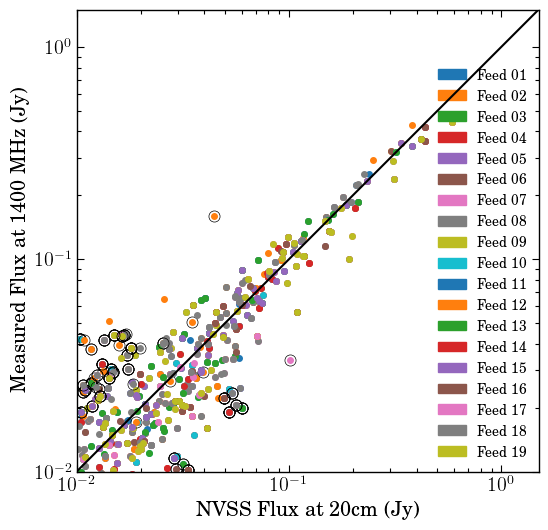

In [282]:
base_path = '/scratch3/users/ycli/fanalysis/'
for suffix in ['_iso6', ]:

    nvss_path = base_path + '/nvss_tod%s/'%suffix
    nvss_list = [
        nvss_path + '20210302_HIMGS_1100+2600.h5',
        nvss_path + '20210305_HIMGS_1100+2632.h5',
        nvss_path + '20210306_HIMGS_1100+2643.h5',
        nvss_path + '20210307_HIMGS_1100+2654.h5',
        nvss_path + '20210309_HIMGS_1100+2610.h5',
        #nvss_path + '20210313_HIMGS_1100+2621.h5',
        #nvss_path + '20210314_HIMGS_1100+2610.h5',
    ]

    beam_list = range(1, 20)
    flux_diff_path = base_path + '/flux_diff_dlim1.5%s'%suffix
    output_flux_beam(map_info, nvss_list, nvss_map_info, beam_list=beam_list, 
                     axes=None, dlim=1.5, flux_diff_path = flux_diff_path)


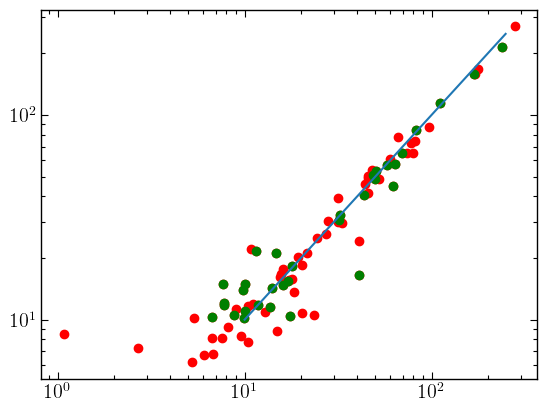

In [12]:
base_path = '/scratch3/users/ycli/fanalysis/'
for suffix in ['_iso6', ]:

    nvss_path = base_path + '/nvss_tod%s/'%suffix
    nvss_list = [
        nvss_path + '20210302_HIMGS_1100+2600.h5',
        nvss_path + '20210305_HIMGS_1100+2632.h5',
        nvss_path + '20210306_HIMGS_1100+2643.h5',
        nvss_path + '20210307_HIMGS_1100+2654.h5',
        nvss_path + '20210309_HIMGS_1100+2610.h5',
        #nvss_path + '20210313_HIMGS_1100+2621.h5',
        #nvss_path + '20210314_HIMGS_1100+2610.h5',
    ]

    beam_list = range(1, 2)
    for _s in load_nvss_by_beam(nvss_list, beam_list, dlim=1.5):
        s_name, s_flux, s_ra, s_dec, tod_flux, d, s_flux_w_beam = _s
        #print np.exp( -0.5* (d/2.9)**2 )
        #print s_flux, tod_flux
        plt.plot(tod_flux, s_flux_w_beam,  'ro')
    for _s in load_nvss_by_beam(nvss_list, beam_list, dlim=0.5):
        s_name, s_flux, s_ra, s_dec, tod_flux, d, s_flux_w_beam = _s
        #print np.exp( -0.5* (d/2.9)**2 )
        #print s_flux, tod_flux
        plt.plot(tod_flux, s_flux_w_beam,  'go')
    plt.plot(np.arange(10, 250), np.arange(10, 250))
    plt.loglog()

Beam 01: rms 0.101061
Average : rms 2.587706 (0.101061) 
--------------------
Beam 02: rms 0.107754
Beam 03: rms 0.195538
Beam 04: rms 0.156156
Beam 05: rms 0.151760
Beam 06: rms 0.306536
Beam 07: rms 0.154785
Average : rms 3.884930 (0.168189) 
--------------------
Beam 08: rms 0.153613
Beam 09: rms 0.180954
Beam 10: rms 0.270064
Beam 11: rms 0.160408
Beam 12: rms 0.169791
Beam 13: rms 0.116024
Beam 14: rms 0.194121
Beam 15: rms 0.159566
Beam 16: rms 0.140718
Beam 17: rms 0.104525
Beam 18: rms 0.158374
Beam 19: rms 0.154915
Average : rms 3.675120 (0.160970) 
--------------------


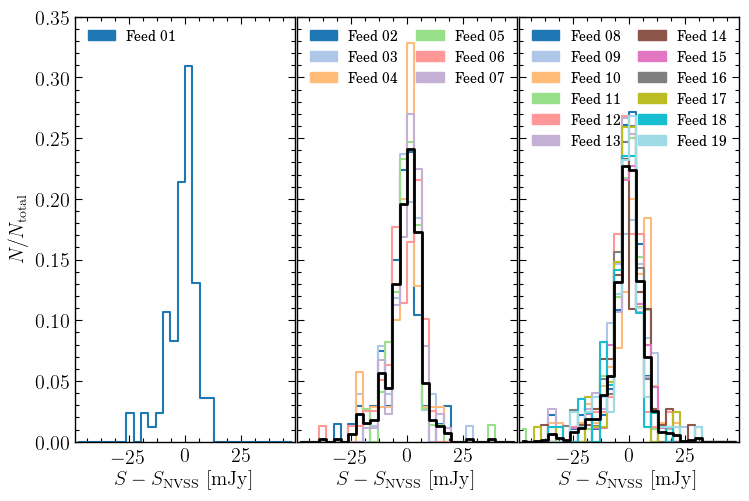

In [12]:
base_path = '/scratch3/users/ycli/fanalysis/'
dlim = 1.5
for suffix in ['_iso6', ]:

    nvss_path = base_path + '/nvss_tod%s/'%suffix
    nvss_list = [
        nvss_path + '20210302_HIMGS_1100+2600.h5',
        nvss_path + '20210305_HIMGS_1100+2632.h5',
        nvss_path + '20210306_HIMGS_1100+2643.h5',
        nvss_path + '20210307_HIMGS_1100+2654.h5',
        nvss_path + '20210309_HIMGS_1100+2610.h5',
        #nvss_path + '20210313_HIMGS_1100+2621.h5',
        #nvss_path + '20210314_HIMGS_1100+2610.h5',
    ]
    
    flux_diff_path = base_path + '/flux_diff_dlim%2.1f%s'%(dlim, suffix)
    
    #fig = plot_flux_allbeam(flux_diff_path, tod=True, nvss_file_list=nvss_list)
    #fig.savefig(base_path + '/flux_comp_dlim%2.1f%s_tod.png'%(dlim, suffix), formate='png', dpi=300)
    #plt.show()
    fig = plot_flux_hist_allbeam(flux_diff_path, rms_sys=None, tod=True)
    #fig.savefig(base_path + '/flux_diff_hist_dlim%2.1f%s_tod.png'%(dlim, suffix), formate='png', dpi=300)
    #plt.show()
    
    #fig = plot_flux_allbeam(flux_diff_path, tod=False, nvss_file_list=nvss_list)
    #fig.savefig(base_path + '/flux_comp_dlim%2.1f%s_map.png'%(dlim, suffix), formate='png', dpi=300)
    #plt.show()
    #fig = plot_flux_hist_allbeam(flux_diff_path, tod=False)
    #fig.savefig(base_path + '/flux_diff_dlim%2.1f%s_map.png'%(dlim, suffix), formate='png', dpi=300)
    #plt.show()
    
    #flux_diff_path = base_path + '/flux_diff_dlim0.5%s'%suffix
    #fig = plot_flux_allbeam(flux_diff_path, tod=False)
    #fig.savefig(base_path + '/flux_comp_dlim0.5%s.png'%suffix, formate='png', dpi=300)
    #plt.show()
    #fig = plot_flux_hist_allbeam(flux_diff_path, rms_sys=None, tod=False)
    #fig.savefig(base_path + '/flux_diff_hist_dlim0.5%s.png'%suffix, formate='png', dpi=300)


0.0013769861537054808
0.02928995929296253 -0.005022974852446971
0.0031460681764488925
2.20484739937664 -0.3020522100147134
0.004025076900260623
20.3625978266168 -0.30497964726226023


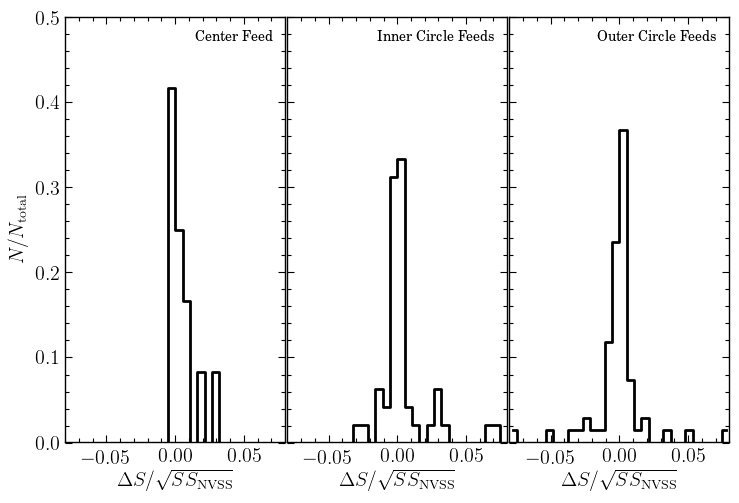

In [218]:
def plot_flux_hist_beam_twodays(nvss_A, nvss_B, beam_list=[1, ], axes=None):
    
    if axes is None:
        fig = plt.figure(figsize = (6, 6))
        ax = fig.subplots()
    else:
        fig, ax = axes

    #bins = np.linspace(-50, 70, 41)
    bins = np.linspace(-0.08, 0.08, 31)
    bins_c = 0.5 * ( bins[:-1] + bins[1:] )
    hist_list = []
    sigma_list = []
    legend_list = []
    
    s_A = [ _s for _s in load_nvss_by_beam([nvss_A,], beam_list, dlim=dlim) ]
    s_B = [ _s for _s in load_nvss_by_beam([nvss_B,], beam_list, dlim=dlim) ]
    diff = []
    for _sA in s_A:
        for _sB in s_B:
            if _sA[0] == _sB[0]:
                x = _sA[4]
                y = _sB[4]
                if x <= 0 or y <= 0:
                    continue
                #print x, y, x - y
                diff.append( (x - y) / (x*y)*0.5)

    
    diff = np.array(diff)
    print np.median(diff ** 2.) ** 0.5
    print diff.max(), diff.min()
    hist = np.histogram(diff, bins=bins)[0] * 1.
    hist /= np.sum(hist)
        
    l = ax.plot(bins_c, hist, 'k-', drawstyle='steps-mid', lw=2.0)[0]
    #legend_list.append(mpatches.Patch(color=l.get_color(), label='Feed %02d'%i))

    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(1.e-4, 0.5)
    #ax.loglog()
    #ax.semilogy()
    #ax.legend(handles=legend_list, frameon=False, markerfirst=True)
    #ax.set_aspect('equal')
    #if axes is None:
    #    ax.set_xlabel('NVSS Flux at 1400 MHz (Jy)')
    #    ax.set_ylabel('Measured Flux at 1400 MHz (Jy)')

    return fig, ax
    #for _s in :
    #    s_name, s_flux, s_ra, s_dec, tod_flux, d, s_flux_w_beam = _s
    
def plot_flux_hist_allbeam_twodays(nvss_A, nvss_B):
    
    fig = plt.figure(figsize = (8, 5))
    gs = gridspec.GridSpec(1, 3, figure=fig, top=0.95, bottom=0.1, left=0.12, right=0.95,
                           wspace=0.01, hspace=0.01)
    
    ax =fig.add_subplot(gs[0, 0])
    beam_list = [1, ]
    plot_flux_hist_beam_twodays(nvss_A, nvss_B, beam_list, axes=(fig, ax))
    ax.set_xlabel(r'$ \Delta S / \sqrt{S S_{\rm NVSS}} $')
    ax.set_ylabel(r'$N/N_{\rm total}$')
    ax.legend(title='Center Feed')
    
    ax =fig.add_subplot(gs[0, 1])
    beam_list = [2, 3, 4, 5, 6, 7]
    plot_flux_hist_beam_twodays(nvss_A, nvss_B, beam_list, axes=(fig, ax))
    ax.set_xlabel(r'$ \Delta S / \sqrt{S S_{\rm NVSS}} $')
    #ax.set_xlabel(r'$ S - S_{\rm NVSS} ~ [{\rm mJy}]$')
    ax.set_yticklabels([])
    ax.legend(title='Inner Circle Feeds')
    
    ax =fig.add_subplot(gs[0, 2])
    beam_list = [8, 9, 10, 11, 12, 13] + [14, 15, 16, 17, 18, 19] 
    plot_flux_hist_beam_twodays(nvss_A, nvss_B, beam_list, axes=(fig, ax))
    ax.set_xlabel(r'$ \Delta S / \sqrt{S S_{\rm NVSS}} $')
    #ax.set_xlabel(r'$ S - S_{\rm NVSS} ~ [{\rm mJy}]$')
    ax.set_yticklabels([])
    ax.legend(title='Outer Circle Feeds')

    return fig
        
base_path = '/scratch3/users/ycli/fanalysis/'
for suffix in ['_iso2', ]:

    nvss_path = base_path + '/nvss_tod%s/'%suffix
    nvss_list = [
        #nvss_path + '20210302_HIMGS_1100+2600.h5',
        #nvss_path + '20210305_HIMGS_1100+2632.h5',
        #nvss_path + '20210306_HIMGS_1100+2643.h5',
        #nvss_path + '20210307_HIMGS_1100+2654.h5',
        nvss_path + '20210309_HIMGS_1100+2610.h5',
        #nvss_path + '20210313_HIMGS_1100+2621.h5',
        nvss_path + '20210314_HIMGS_1100+2610.h5',
    ]
    
fig = plot_flux_hist_allbeam_twodays(nvss_list[0], nvss_list[1])
fig.savefig('output/flux_twodays.png', formate='png', dpi=300)

In [ ]:
    for i in beam_list:
        data_flux_diff = np.loadtxt(flux_diff_path + '_beam%02d.txt'%i)
        
        nvss_name = data_flux_diff[:, :3]
        if tod:
            #y = data_flux_diff[:, 5] # flux measured tod
            y = data_flux_diff[:, 5]
            x = data_flux_diff[:, 7]
        else:
            y = data_flux_diff[:, 4] # flux measured
            x = data_flux_diff[:, 6]
        #x = data_flux_diff[:, 3] # flux from nvss map

        good = ( x > 1.e-1 ) * ( y > 1.e-1 ) 
        x = x[good]
        y = y[good]
        
        #diff = y/x - 1
        diff = (x - y) #/ (x + y)
        #print x.min(), x.max()
        sigma2 = np.sqrt( np.mean( (x - y) ** 2 / (x * y) ) )
        sigma_list.append( (x - y) ** 2)
        print 'Beam %02d: rms %f'%(i, sigma2)

        hist = np.histogram(diff, bins=bins)[0] * 1.
        hist_list.append(hist[None, :])
        hist /= np.sum(hist)
        
        l = ax.plot(bins_c, hist, '-', drawstyle='steps-pre')[0]
        legend_list.append(mpatches.Patch(color=l.get_color(), label='Feed %02d'%i))
        
        #ax.axvline(sigma2, 0, 1, color=l.get_color(), ls='--')

        #print 'Beam %02d'%i
        #for ii in range(bad.shape[0]):
        #    if ( x[sel][ii] > 0.01 ) and ( y[sel][ii] > 0.01 ):
        #        print '%d %f %f'%tuple(bad[ii]) + ' %f %f'%(x[sel][ii], y[sel][ii])
        
    if len(hist_list) > 1:
        hist = np.concatenate(hist_list, axis=0)
        hist = np.sum(hist, axis=0)
        hist /= np.sum(hist)
        ax.plot(bins_c, hist, 'k-', linewidth=2., drawstyle='steps-pre')
    
    sigma_list = np.concatenate(sigma_list)
    print sigma_list.shape
    sigma2 = np.sqrt(np.mean(sigma_list))
    print 'Average : rms %f'%(sigma2)
    print '-'*20
    if rms_sys is not None:
        n_freq = 50.e3 / 28.
        n_pixs = (2.99 / 1.7)**2
        print rms_sys/np.sqrt(n_freq * n_pixs)
        ax.axvline( rms_sys/np.sqrt(n_freq * n_pixs), 0, 1, color='k', ls='--')
        ax.axvline(-rms_sys/np.sqrt(n_freq * n_pixs), 0, 1, color='k', ls='--')
    

    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(1.e-4, 0.35)
    #ax.loglog()
    #ax.semilogy()
    ax.legend(handles=legend_list, frameon=False, markerfirst=True)
    #ax.set_aspect('equal')
    if axes is None:
        ax.set_xlabel('NVSS Flux at 1400 MHz (Jy)')
        ax.set_ylabel('Measured Flux at 1400 MHz (Jy)')

    return fig, ax

In [125]:
eta = 1.0
_lambda = 2.99e8 / (1400 * 1.e6)
_Omega = np.pi * (2.99/60. * np.pi/180.)**2. / 4. / np.log(2.)
_K2mJy = 2. * 1380. / (_lambda**2.) * 1.e3 * _Omega
print _K2mJy
print 1./_K2mJy * 1.e3
print 1.e3/19.2

51.86588683816185
19.280495542673737
52.0833333333


ID:755887, RA,Dec=(10h04m56.47s, 26d32m13.16s)


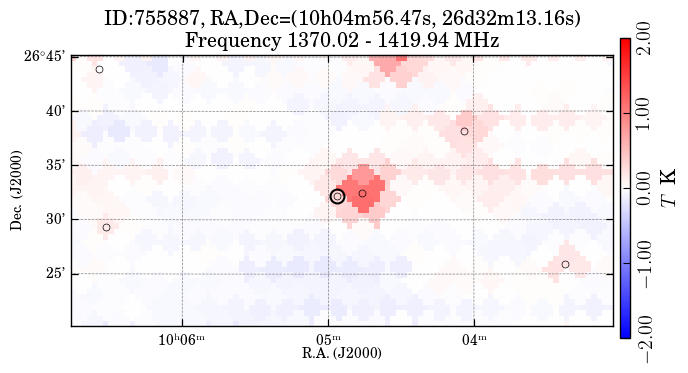

ID:791530, RA,Dec=(10h33m40.04s, 26d42m57.78s)


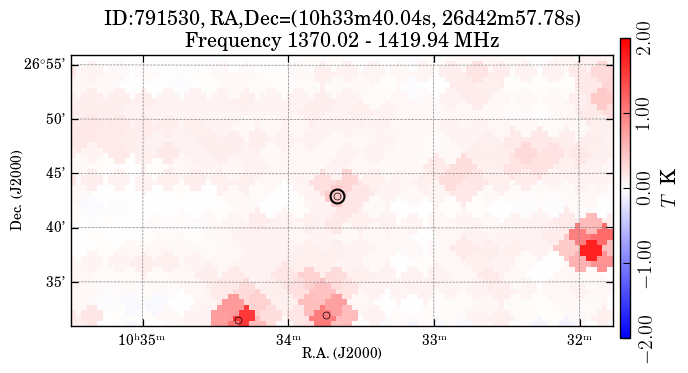

In [156]:
map_name = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/Combined_1250-1450MHz.h5'
output_path = '/scratch3/users/ycli/fanalysis/bad_sources/'         
bad_sources = np.loadtxt('/scratch3/users/ycli/fanalysis/bad_sources/source_list.txt')

nvss_path = None
nvss_path = '/idia/users/ycli/NVSS/nvss_N25-N27.fits'

nvss_path = [
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_135RA140.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_140RA145.fits', 
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_145RA150.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_150RA155.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_155RA160.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_160RA165.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_165RA170.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_170RA175.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_180RA185.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_185RA190.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_190RA195.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_195RA200.fits',
]
flux_key = 'NVSS_FLUX'
name_key = 'NVSS_ID'

nvss_map_path = '/scratch3/users/ycli/fanalysis/firstnvss_map_th1_nside2048_beam.h5'


for ii in range(bad_sources.shape[0])[:2]:
    bs = bad_sources[ii]
    ra = bs[1] * u.deg
    dec= bs[2] * u.deg
    s = SkyCoord(ra, dec)
    ra = '%02dh%02dm%4.2fs'%s.ra.hms
    dec= '%02dd%02dm%4.2fs'%s.dec.dms
    title = 'ID:%d,'%(bs[0]) + ' RA,Dec=(%s, %s)'%(ra, dec)
    print title
    
    axes = None
    axes = plot_map.plot_map_hp(map_name, map_key='clean_map',
                         pix=0.5/60., indx=(slice(1532, 3169), ),
                         imap_shp = (100, 50), axes=axes,
                         field_center=[(bs[1], bs[2])],
                         figsize=(7, 5), vmin=-2., vmax=2., sigma = None,
                         title=title + '\n', proj='ZEA', cmap='bwr', 
                         nvss_path=None)
    ax = axes[1][0]
    
    dra = 0.5/60.*50
    ddec = 0.5/60.*25
    nvss_range = [ [bs[1]-dra, bs[1]+dra, bs[2]-ddec, bs[2]+ddec],]
    nvss_ra, nvss_dec, nvss_flx, nvss_name = load_catalogue(nvss_path, nvss_range, flux_key, name_key)

    ax.plot(nvss_ra, nvss_dec, 'o', mec='k', mfc='none', ms=5, mew=0.5, transform=ax.get_transform('icrs'))
    ax.plot(bs[1], bs[2], 'o', mec='k', mfc='none', ms=10, mew=1.5, transform=ax.get_transform('icrs'))

    fig = axes[0]
    #fig.savefig(output_path + 'ID%d.png'%bs[0])
    plt.show()

ID:755887 RA:       151.2352900 Dec:        26.5369900 Flux 0.024316 0.070140
ID:791530 RA:       158.4168500 Dec:        26.7160500 Flux 0.016661 0.038213


/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:81: RuntimeWarning: divide by zero encountered in divide


(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f73cf7c74d0>)

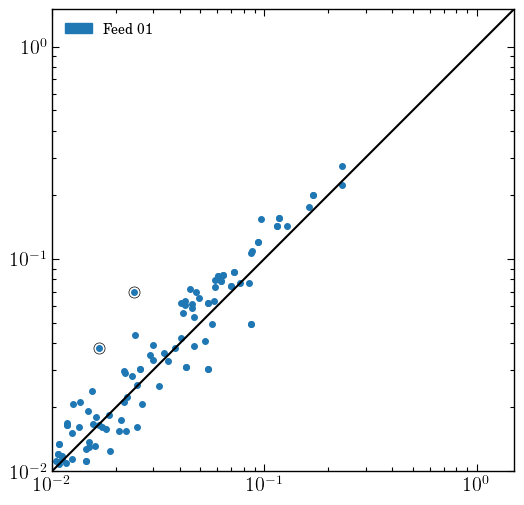

In [127]:
nvss_path = '/scratch3/users/ycli/fanalysis/nvss_tod/'
nvss_list = [
    nvss_path + '20210302_HIMGS_1100+2600.h5',
    nvss_path + '20210305_HIMGS_1100+2632.h5',
    nvss_path + '20210306_HIMGS_1100+2643.h5',
    nvss_path + '20210307_HIMGS_1100+2654.h5',
    nvss_path + '20210309_HIMGS_1100+2610.h5',
    #nvss_path + '20210313_HIMGS_1100+2621.h5',
    nvss_path + '20210314_HIMGS_1100+2610.h5',
]

fig = plt.figure(figsize = (6, 6))
ax = fig.subplots()

plot_flux_beam(map_info, nvss_list, nvss_map_info, beam_list=[1, ], axes=(fig, ax), dlim=0.5)